In [8]:
import numpy as np
from random import random
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim

import random
import os
import time
import matplotlib.pyplot as plt

from torch.autograd import Variable

In [9]:
class follower:
    
    def __init__(self,X0,dt):
        self.X  = X0
        self.dt = dt
        
    def step(self,u,w):
        
        self.X = self.X + np.array([u*np.cos(self.X[2]),u*np.sin(self.X[2]),w])*dt
        
        return self.X
    
    def render(self,lines,areas,body):
        length = 5
        FoV = np.pi/3

        x = np.array([self.X[0],self.X[1]])
        theta = self.X[2]
        theta1 = theta + FoV/2
        theta2 = theta - FoV/2
        e1 = np.array([np.cos(theta1),np.sin(theta1)])
        e2 = np.array([np.cos(theta2),np.sin(theta2)])

        P1 = x + length*e1
        P2 = x + length*e2  

        triangle_hx = [x[0] , P1[0], P2[0], x[0] ]
        triangle_hy = [x[1] , P1[1], P2[1], x[1] ]
        triangle_v = [ x,P1,P2,x ]  

        lines.set_data(triangle_hx,triangle_hy)
        areas.set_xy(triangle_v)

        length2 = 3

        # scatter plot update
        body.set_offsets([x[0],x[1]])
#         sc.set_offsets(np.c_[x,y])

        return lines, areas, body
       
class target:
    
    def __init__(self,X0,dt):
        self.X = X0
        self.dt = dt
        self.t0 = 0
        self.speed = 0
        self.theta = 0
        
    def step(self,a,alpha):
        
        if (self.speed<2):
            self.speed = self.speed + a*self.dt
            
        self.theta = self.theta + alpha*dt
        
        if self.theta>np.pi:
            self.theta = self.theta - 2*np.pi
        if self.theta<-np.pi:
            self.theta = self.theta + 2*np.pi
        
        self.X = self.X + np.array([ self.speed*np.cos(self.theta),self.speed*np.sin(self.theta) ])*dt
        return self.X
    
    def render(self,body):
        length = 3
        FoV = np.pi/3

        x = np.array([self.X[0],self.X[1]])

        # scatter plot update
        body.set_offsets([x[0],x[1]])
#         sc.set_offsets(np.c_[x,y])

        return body
    
def wrap_angle(angle):
    if angle>np.pi:
        angle = angle - 2*np.pi
    if angle<-np.pi:
        angle = angle + 2*np.pi
    return angle
    
def compute_reward(F_X,T_X):
    
    FoV = 30*np.pi/180
    max_D = 3
    min_D = 0.3
    beta = np.arctan2(T_X[1]-F_X[1],T_X[0]-F_X[0])
    
    angle_diff = wrap_angle(beta - F_X[2])
    
    distance = np.sqrt( (T_X[0]-F_X[0])**2 + (T_X[1]-F_X[1])**2 )
    
    if np.abs(angle_diff)>FoV:
        reward_angle = -1
    else:
        reward_angle = np.abs(FoV-angle_diff)/FoV
    
    if distance>max_D:
        reward_distance = -1
    elif distance<min_D:
        reward_distance = -1
    else:
        reward_distance = np.abs(distance-min_D)*np.abs(distance-max_D)*4/(max_D-min_D)**2
        
    reward = reward_angle*reward_distance
    
    return reward
    

In [10]:
def decode_action(action):
        if action==0:
            u = 0;v=0             
        elif action==1:
            u = 0;v=0.4
        elif action==2:
            u = 0;v=-0.4
        elif action==3:
            u = 1;v=0
        elif action==4:
            u = 1;v=0.4
        else: # action==5:
            u = 1;v=-0.4
        return u,v

In [20]:
def eval_policy(agent,env_name,eval_episodes=10):
    #initialize
    
    avg_reward = 0.
    
    plt.ion()

    fig = plt.figure()
    ax = plt.axes(xlim=(0,20),ylim=(-10,10))

    lines, = ax.plot([],[],'o-')
    areas, = ax.fill([],[],'r')
    bodyF = ax.scatter([],[],c='r',s=10)
    
    bodyT = ax.scatter([],[],c='g',s=10)

    for _ in range(eval_episodes):
        agentF = follower(np.array([0,0.2,0]),dt)
        agentT = target(np.array([1,0]),dt)
        done = False
        while not done:
            T = agentT.X
            F = agentF.X    
            #print(T)
            #print(F)
            state = np.array([F[0],F[1],F[2],T[0],T[1]])
    
            action = agent.policy(state)
            u,v = decode_action(action)
            
            T_ns = agentT.step(0.2,0.5)        
            F_ns = agentF.step(u,v)
            reward = compute_reward(F_ns,T_ns)
            
            #print(reward)
            
            lines, areas, bodyF = agentF.render(lines,areas,bodyF)
            bodyT = agentT.render(bodyT)
            
            fig.canvas.draw()
            fig.canvas.flush_events()
            
            if reward<0:
                done = True
                #print("done")
            #print("running")
   
            avg_reward += reward
    plt.close()
    avg_reward /= eval_episodes
    #print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

In [12]:
class NETWORK(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int) -> None:

        super(NETWORK, self).__init__()

        self.layer1 = torch.nn.Sequential(
             torch.nn.Linear(input_dim, hidden_dim),
             torch.nn.ReLU()
         )

        self.layer2 = torch.nn.Sequential(
           torch.nn.Linear(hidden_dim, hidden_dim),
           torch.nn.ReLU()
        )

        self.adv = nn.Linear(hidden_dim,output_dim)
        self.val = nn.Linear(hidden_dim,1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = self.layer2(x)
        adv = self.adv(x)
        val = self.val(x)
        x = val + adv - adv.mean(1,keepdim=True)
        return x



class DQN(object):
    def __init__(self):
        self.action_dim = 6  # 2 speeds x 3 angular
        self.state_dim = 5 # 3 F + 2 T
        self.hidden_dim = 64

        self.epsilon = 0.1  
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.gamma = 0.98           # discount factor
        self.beta = 0.001           # Learning Rate #0.3 

        # Behaviour Policy
        self.primal_network = NETWORK(self.state_dim, self.action_dim, self.hidden_dim)
        self.optimizer_primal = optim.Adam(self.primal_network.parameters(),self.beta)
        
        # Target Policy
        self.target_network = NETWORK(self.state_dim, self.action_dim, self.hidden_dim)

        self.replay_buffer = 50000     # All dataset
        self.batch_size = 64           # Randomly sample a batch from replay buffer
        self.target_update = 4 # No. of episodes
        self.episode_counter = 0

        self.memory = []

        self.counter = 0

    def select_action(self, states: np.ndarray) -> int:
        
        if (np.random.random()<self.epsilon):
            # Exploration
            with torch.no_grad():
                action = torch.tensor( [ [random.randrange(self.action_dim)] ] )   #int(np.random.choice(2, 1))
                action = action.item()
        else:
                # Exploitation
                action = self.policy(states)
        #print(action,states)
        return action

    def policy(self, states: np.ndarray) -> int:  # policy is primal network?

        states = torch.FloatTensor(states).unsqueeze(0)
        with torch.no_grad():
                action = self.primal_network(states).max(1)[1].view(1,1)
        return action.item()

    def train(self,s0,a0,r,s1,sign):

        if sign==1:
            self.episode_counter += 1
            
        if (len(self.memory)>self.replay_buffer):
            del self.memory[0]

        self.memory.append((s0,a0,r,s1,sign))
        
        if len(self.memory)>=2*self.batch_size:

            if ( (self.episode_counter>=1) and (self.episode_counter % self.target_update == 0) ) :
                self.target_network.load_state_dict(self.primal_network.state_dict())
                self.episode_counter = 0
            
            transitions = random.sample(self.memory, self.batch_size)
            batch_state, batch_action, batch_reward, batch_next_state, batch_terminal = zip(*transitions)
            
            batch_state = torch.FloatTensor(batch_state)
            batch_action = torch.LongTensor(batch_action)
            batch_reward = torch.FloatTensor(batch_reward)
            batch_next_state = torch.FloatTensor(batch_next_state)
            batch_terminal = torch.FloatTensor(batch_terminal)

            Q_values = self.primal_network(batch_state)[range(self.batch_size), batch_action]  #.data

            with torch.no_grad():
                next_action = self.primal_network( batch_next_state ).max(1)[1]
                next_state_values = self.target_network(batch_next_state)[range(self.batch_size), next_action]
                expected_Q_values = batch_reward + self.gamma*(1 - batch_terminal)*next_state_values

            loss = (Q_values - expected_Q_values).pow(2).mean()

            self.optimizer_primal.zero_grad()
            loss.backward()
            self.optimizer_primal.step()

        if sign==1:
         	if self.epsilon > self.epsilon_min*self.epsilon_decay:
         		self.epsilon *= self.epsilon_decay
        	

episode: 0, reward: 2.1406565623161375
Evaluation over 50 episodes: 2.899
---------------------------------------
2.899268502269719
episode: 1, reward: 1.8762465547455696
episode: 2, reward: 1.8762465547455696
episode: 3, reward: 1.8762465547455696
episode: 4, reward: 1.8762465547455696
episode: 5, reward: 1.8762465547455696
Evaluation over 50 episodes: 2.899
---------------------------------------
2.899268502269719
episode: 6, reward: 2.9049255468799515
episode: 7, reward: 1.8762465547455696
episode: 8, reward: 1.9892560411014355
episode: 9, reward: 1.8762465547455696
episode: 10, reward: 2.705083332660707
Evaluation over 50 episodes: 2.899
---------------------------------------
2.899268502269719
episode: 11, reward: 1.8762465547455696
episode: 12, reward: 1.8762465547455696
episode: 13, reward: 1.8762465547455696
episode: 14, reward: 2.5033228824772022
episode: 15, reward: 1.8762465547455696
Evaluation over 50 episodes: 2.899
---------------------------------------
2.899268502269719

KeyboardInterrupt: 

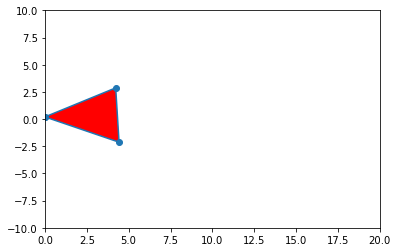

In [21]:
env_name = 'Target-Follower'
#env = gym.make(env_name)

dt = 0.1

    
agent = DQN() 

start_time = time.time()

reward_plot = []

# plt.ion()
# fig = plt.figure()
# ax = plt.axes(xlim=(0,20),ylim=(-10,10))
# lines, = ax.plot([],[],'o-')
# areas, = ax.fill([],[],'r')
# body, = ax.plot([],[],'b',lw='5')
# body_target, = ax.scatter([],[],c='g',s='5')


for i in range(10000):
    #print("start")
    #initialize
    agentF = follower(np.array([0,0,0]),dt)
    agentT = target(np.array([1,0]),dt)
    done = False
    
    episodic_reward = 0
    
    T = agentT.X
    F = agentF.X    
    state = np.array([F[0],F[1],F[2],T[0],T[1]])
    
     #action to input
    
    while not done:
        action = agent.select_action(np.squeeze(state))
        
        u,v = decode_action(action)
        
       
        T_ns = agentT.step(0.2,0.5
                          )        
        F_ns = agentF.step(u,v)
        reward = compute_reward(F_ns,T_ns)
        if reward<0:
            done = True
        #next_state, reward, done, info = env.step(action)
        #env.render()
        episodic_reward += reward      
        sign = 1 if done else 0
        
        state = np.array([F[0],F[1],F[2],T[0],T[1]])
        next_state = np.array([F_ns[0],F_ns[1],F_ns[2],T_ns[0],T_ns[1]])
        
        agent.train(state,action,reward,next_state,sign)
        #print('here')
        next_state = state
    print (f'episode: {i}, reward: {episodic_reward}')         
    if i % 5 == 0:
        eval_reward = eval_policy(agent,env_name,eval_episodes=50)
        reward_plot.append(eval_reward)
        #env.render()
        print(eval_reward)
        if eval_reward >= 100:
            print("Problem solved in {} episodes".format(i + 1))
            break
    #print("done?")
    #print(i)


print('Complete')
#env.render()
#env.close()


print("----------- seconds ------------")
print(time.time() - start_time)

In [7]:
a*b

array([ 2,  6, 12])

In [24]:
u=2,v=3

SyntaxError: cannot assign to literal (<ipython-input-24-dccffd348434>, line 1)

In [26]:
u=2;v=3

In [27]:
v

3

In [58]:
x = torch.tensor(0.4435, dtype=torch.float64)

In [59]:
x


tensor(0.4435, dtype=torch.float64)

In [60]:
x>0.2

tensor(True)

In [61]:
x<0.2

tensor(False)

In [63]:
if (x>0.2):
    print("wrong")

wrong
